# Main content boundary identification in fiction and non-fiction works in the HathiTrust digital library

In [1]:
import pandas as pd
import collections
from collections import Counter
import numpy as np
import htrc_features
from htrc_features import Volume
from htrc_features import utils
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

### Accessing the Extracted Features dataset through the htrc_features library and its Volume method

In [2]:
volume_pages = Volume('msu.31293015784899') #HathiTrust id for a work
#msu.31293015784899 - A public domain edition of 'Jane Eyre' (1911)
#ucw.ark:/13960/t07w6r028 - A public domain edition of'The Adventures of Tom Sawyer' (1899)
#hvd.hn6mhj - A publid domain edition of 'David Copperfield' (1906)
#mdp.39015042089402 - A public domain edition of 'The House of Mirth' (1905)

### Flattening the format of extracted features and creating a list of token:count pairs (per page)

In [3]:
d=[]
for page in volume_pages:
    tokens = page.tokenlist(drop_section=True,pos=False, drop_page=False)
    tokens1 = tokens.reset_index() #flattening the file
    tokens2 = tokens1[['token', 'count']] #extracting token and count from extracted features dataset
    token = tokens1['token'].to_list() #converting to a list
    count = tokens1['count'].to_list()
    d2 = dict(zip(token, count)) #creating a dictionary
    d.append(d2)

### Although page column is available from extracted features dataset, not every digitized page is associated with a number in the Extracted Features dataset. This is why we revert to numbering the key:value pairs in the previously created d. 

In [4]:
pages =[]
pgs = enumerate(d, start=1) #getting the page numbers by enumerating the token:count pairs in previously created d. Some page numbers are missing from extracted features dataset and they are needed for establishing the boundary of main content 
for i in pgs:
    pages.append(i[0]) 

### Initializing DictVectorizer()

In [5]:
v = DictVectorizer(sparse=False)

### Counts of tokens on each page are converted into a document matrix

In [6]:
dtm = v.fit_transform(d)  

### Pairwise cosine similarity is calculated and distance between each pair of pages is obtained by subtracting cosine similarity from 1

In [7]:
dist = 1 - cosine_similarity(dtm)# running pairwise cosine similarity on dtm object and subtracting from 1

### Multi dimensional scaling allows viewing of distances between pages in two dimensions

In [8]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)   

### X and Y coordinates are obtained from the multi-dimensional scaling model for plotting

In [9]:
xs, ys = pos[:, 0], pos[:, 1]

### Multi dimensional scaling scatter plot

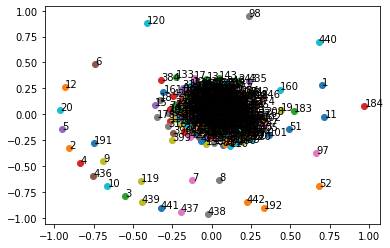

In [10]:
fig = plt.figure(figsize=(6, 4))
for x, y, page in zip(xs, ys, pages): #pags are page numbers that have been extracted from the dictionary
    plt.scatter(x, y)
    plt.text(x, y, page)
plt.savefig('Fig1.jpg', bbox_inches='tight')
    

### The dense cluster in the middle of the graph suggested a dense based clustering algorithm approach. DBSCAN algorithm parameters, eps and min_samples, can be further tuned. Eps parameter indicates how close the points in the cluster need to be in order for them to be considered part of the same cluster. Min_sample parameter indicates the number of minimum samples that the cluster needs to contain to be considered a cluster. Modifying these parameters will produce different results. 

In [11]:
estimator = DBSCAN(eps=0.1, min_samples=3) #very small eps paramater value requiring pages in the cluster to be very close to each other, minimum number of pages in a cluster=3
estimator.fit(pos)
labels = estimator.labels_

### Label/cluster for each page is counted with the Counter() function

In [12]:
print (Counter(labels)) #cluster summery

Counter({0: 408, -1: 34})


### Reducing the number of colors in the graph and eliminating the page numbers allows a better view of the clusters

In [13]:
def set_colors(labels, colors='rgbykcm'): #labels correspond to the clusters
    colored_labels = []
    for label in labels:
        colored_labels.append(colors[label])
    return colored_labels

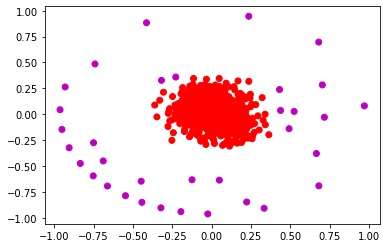

In [14]:
colors = set_colors(labels)
plt.scatter(xs, ys, c=colors)
plt.savefig('Fig2.jpg', bbox_inches='tight')
plt.show()

### Pages and labels are zipped together and saved in a data frame format

In [15]:
df = pd.DataFrame((zip(pages , labels)), columns =['page', 'cluster']) #page and cluster labels are saved in a data frame

### Total number of digitized pages in the work

In [16]:
print(len(df)) #checking the length of the data frame

442


### Conversion of page and cluster columns to int format for accurate sorting 

In [17]:
df['page'] = df['page'].astype(int)
df['cluster'] = df['cluster'].astype(int)

In [18]:
df_sort = df.sort_values(by=['page', 'cluster'],kind="mergesort") #sorting the data frame

### The seaborn FacetGrid visualization indicates main text as a long, continuous orange line

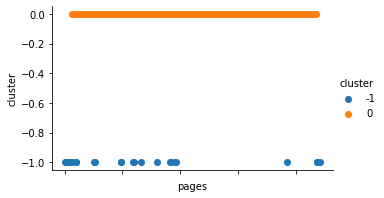

In [19]:
fg = seaborn.FacetGrid(data=df_sort, hue='cluster', aspect=1.61)
fg.map(plt.scatter, 'page', 'cluster').add_legend()
fg.set(xticklabels=[])
fg.set(xlabel='pages')

### Minimum and maximum page associated with 0 cluster (typically the largest cluster) represent the boundaries of the main content

In [20]:
cluster_0 = df_sort['cluster'] == 0
cluster0 = df_sort[cluster_0]
page_min = cluster0['page'].min()
page_max = cluster0['page'].max()

In [21]:
print('Main content starts at page' + ' ' + str(page_min) + ' ' + 'and ends at page' + ' ' + str(page_max) + '.')

Main content starts at page 13 and ends at page 435.


In [22]:
cluster = df_sort['cluster'].tolist() #converting data frame columns to list format for easier manipulation
page = df_sort['page'].tolist()

### Applying majority vote smoothing to the results by evaluating three labels before and three after each element in the cluster/label column

In [23]:
window = 3
context =[] #context labels/majority voting placeholder
for backward, current in enumerate(range(len(cluster)), start=0-window):
    if backward < 0:
        backward = 0
    forward = cluster[current:current+1+window] #labels for three pages after the current page
    backward = cluster[backward:current] #labels for three pages before the current page
    out = forward + backward
    context.append(out)

### Once the context for each label has been established, we establish the most common element which becomes the smoothed result

In [24]:
votes = []
cluster_s =[] # placeholder for smoothed result cluster/label

for list in context:
    i = Counter(list).most_common(1) #majority voting
    votes.append(i)
cluster_votes = [tup[0] for tup in votes] # indicates the surrounding context for each label/cluster, how many votes each cluster/label received
for i in cluster_votes:
    cluster_s.append(i[0]) #results after applying majority voting based on context

In [25]:
cluster_smooth = pd.DataFrame(zip(page, cluster_s), columns = ['page', 'cluster_smooth'])

### Querying the largest cluster (typically cluster 0) for its min and max page that represent the boundary of the main content

In [26]:
cluster_0 = cluster_smooth['cluster_smooth'] == 0
cluster_s_0 = cluster_smooth[cluster_0]
page_min = cluster_s_0['page'].min()
page_max = cluster_s_0['page'].max()

### Updated result indicates the start and end of the main content obtained using unsupervised density based clustering algorithm with smoothing

In [27]:
print('Main content starts at page' + ' ' + str(page_min) + ' ' + 'and ends at page' + ' ' + str(page_max) + '.')

Main content starts at page 13 and ends at page 435.
